# Segmentation + Evaluation

2025-08-02 00:53:20 — INFO — Evaluation notebook start.
2025-08-02 00:53:20 — INFO — Installing python-dotenv (missing)
2025-08-02 00:53:21 — INFO — Installing Pillow (missing)
2025-08-02 00:53:22 — INFO — Installing google-genai (missing)
2025-08-02 00:53:23 — INFO — GenAI client initialized.
2025-08-02 00:53:24 — INFO — BUSI dataset found at D:\Projects\gemini_image_segmentation\data\BUSI
2025-08-02 00:53:24 — INFO — Selected target class for evaluation: benign
2025-08-02 00:53:24 — INFO — Starting evaluation run for model: gemini-2.5-flash on BUSI dataset (Class: benign).
2025-08-02 00:53:24 — INFO — Detailed predictions will be saved to: D:\Projects\gemini_image_segmentation\data\BUSI\predictions_benign_gemini-2.5-flash
2025-08-02 00:53:24 — INFO — Loaded 437 total images for class 'benign'. Will evaluate a sample of 437.


Evaluating benign - gemini-2.5-flash:   0%|          | 0/437 [00:00<?, ?it/s]

2025-08-02 00:53:24 — INFO — Processing: benign (26).png
2025-08-02 00:53:24 — INFO — AFC is enabled with max remote calls: 10.
2025-08-02 00:53:25 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-08-02 00:53:25 — INFO — AFC remote call 1 is done.
2025-08-02 00:53:25 — INFO — Processing: benign (238).png
2025-08-02 00:53:25 — INFO — AFC is enabled with max remote calls: 10.
2025-08-02 00:53:27 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-08-02 00:53:27 — INFO — AFC remote call 1 is done.
2025-08-02 00:53:27 — INFO — Processing: benign (229).png
2025-08-02 00:53:27 — INFO — AFC is enabled with max remote calls: 10.
2025-08-02 00:53:28 — INFO — HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-08-02 00:53:28 — INFO — AFC remo

---------------------------------------------
       GenAI Segmentation Evaluation Report: gemini-2.5-flash on BUSI (Benign)
---------------------------------------------
Total Images Evaluated: 437
IoU Threshold for Success: 0.5
Exclude Low IoU from Stats: True

--- Performance Metrics ---
Mean IoU (Mass):      0.7706 (95% CI: 0.7546 - 0.7844) on 210 images
Mean Dice (Mass):     0.8657 (95% CI: 0.8546 - 0.8758)

--- Operational Metrics ---
Mean API Latency:     7.71s (95% CI: 4.16s - 12.00s)
JSON Parse Success:   93.8%

--- Failure Analysis (based on full dataset) ---
JSON Failures:              27 (6.2%)
False Negatives (Mass):     5 (1.1%)
Low IoU (Mass):             195 (44.6%)
---------------------------------------------


2025-08-02 01:48:33 — INFO — Saved high-resolution IoU plot to D:\Projects\gemini_image_segmentation\data\BUSI\iou_distribution_busi_benign_gemini-2.5-flash.png


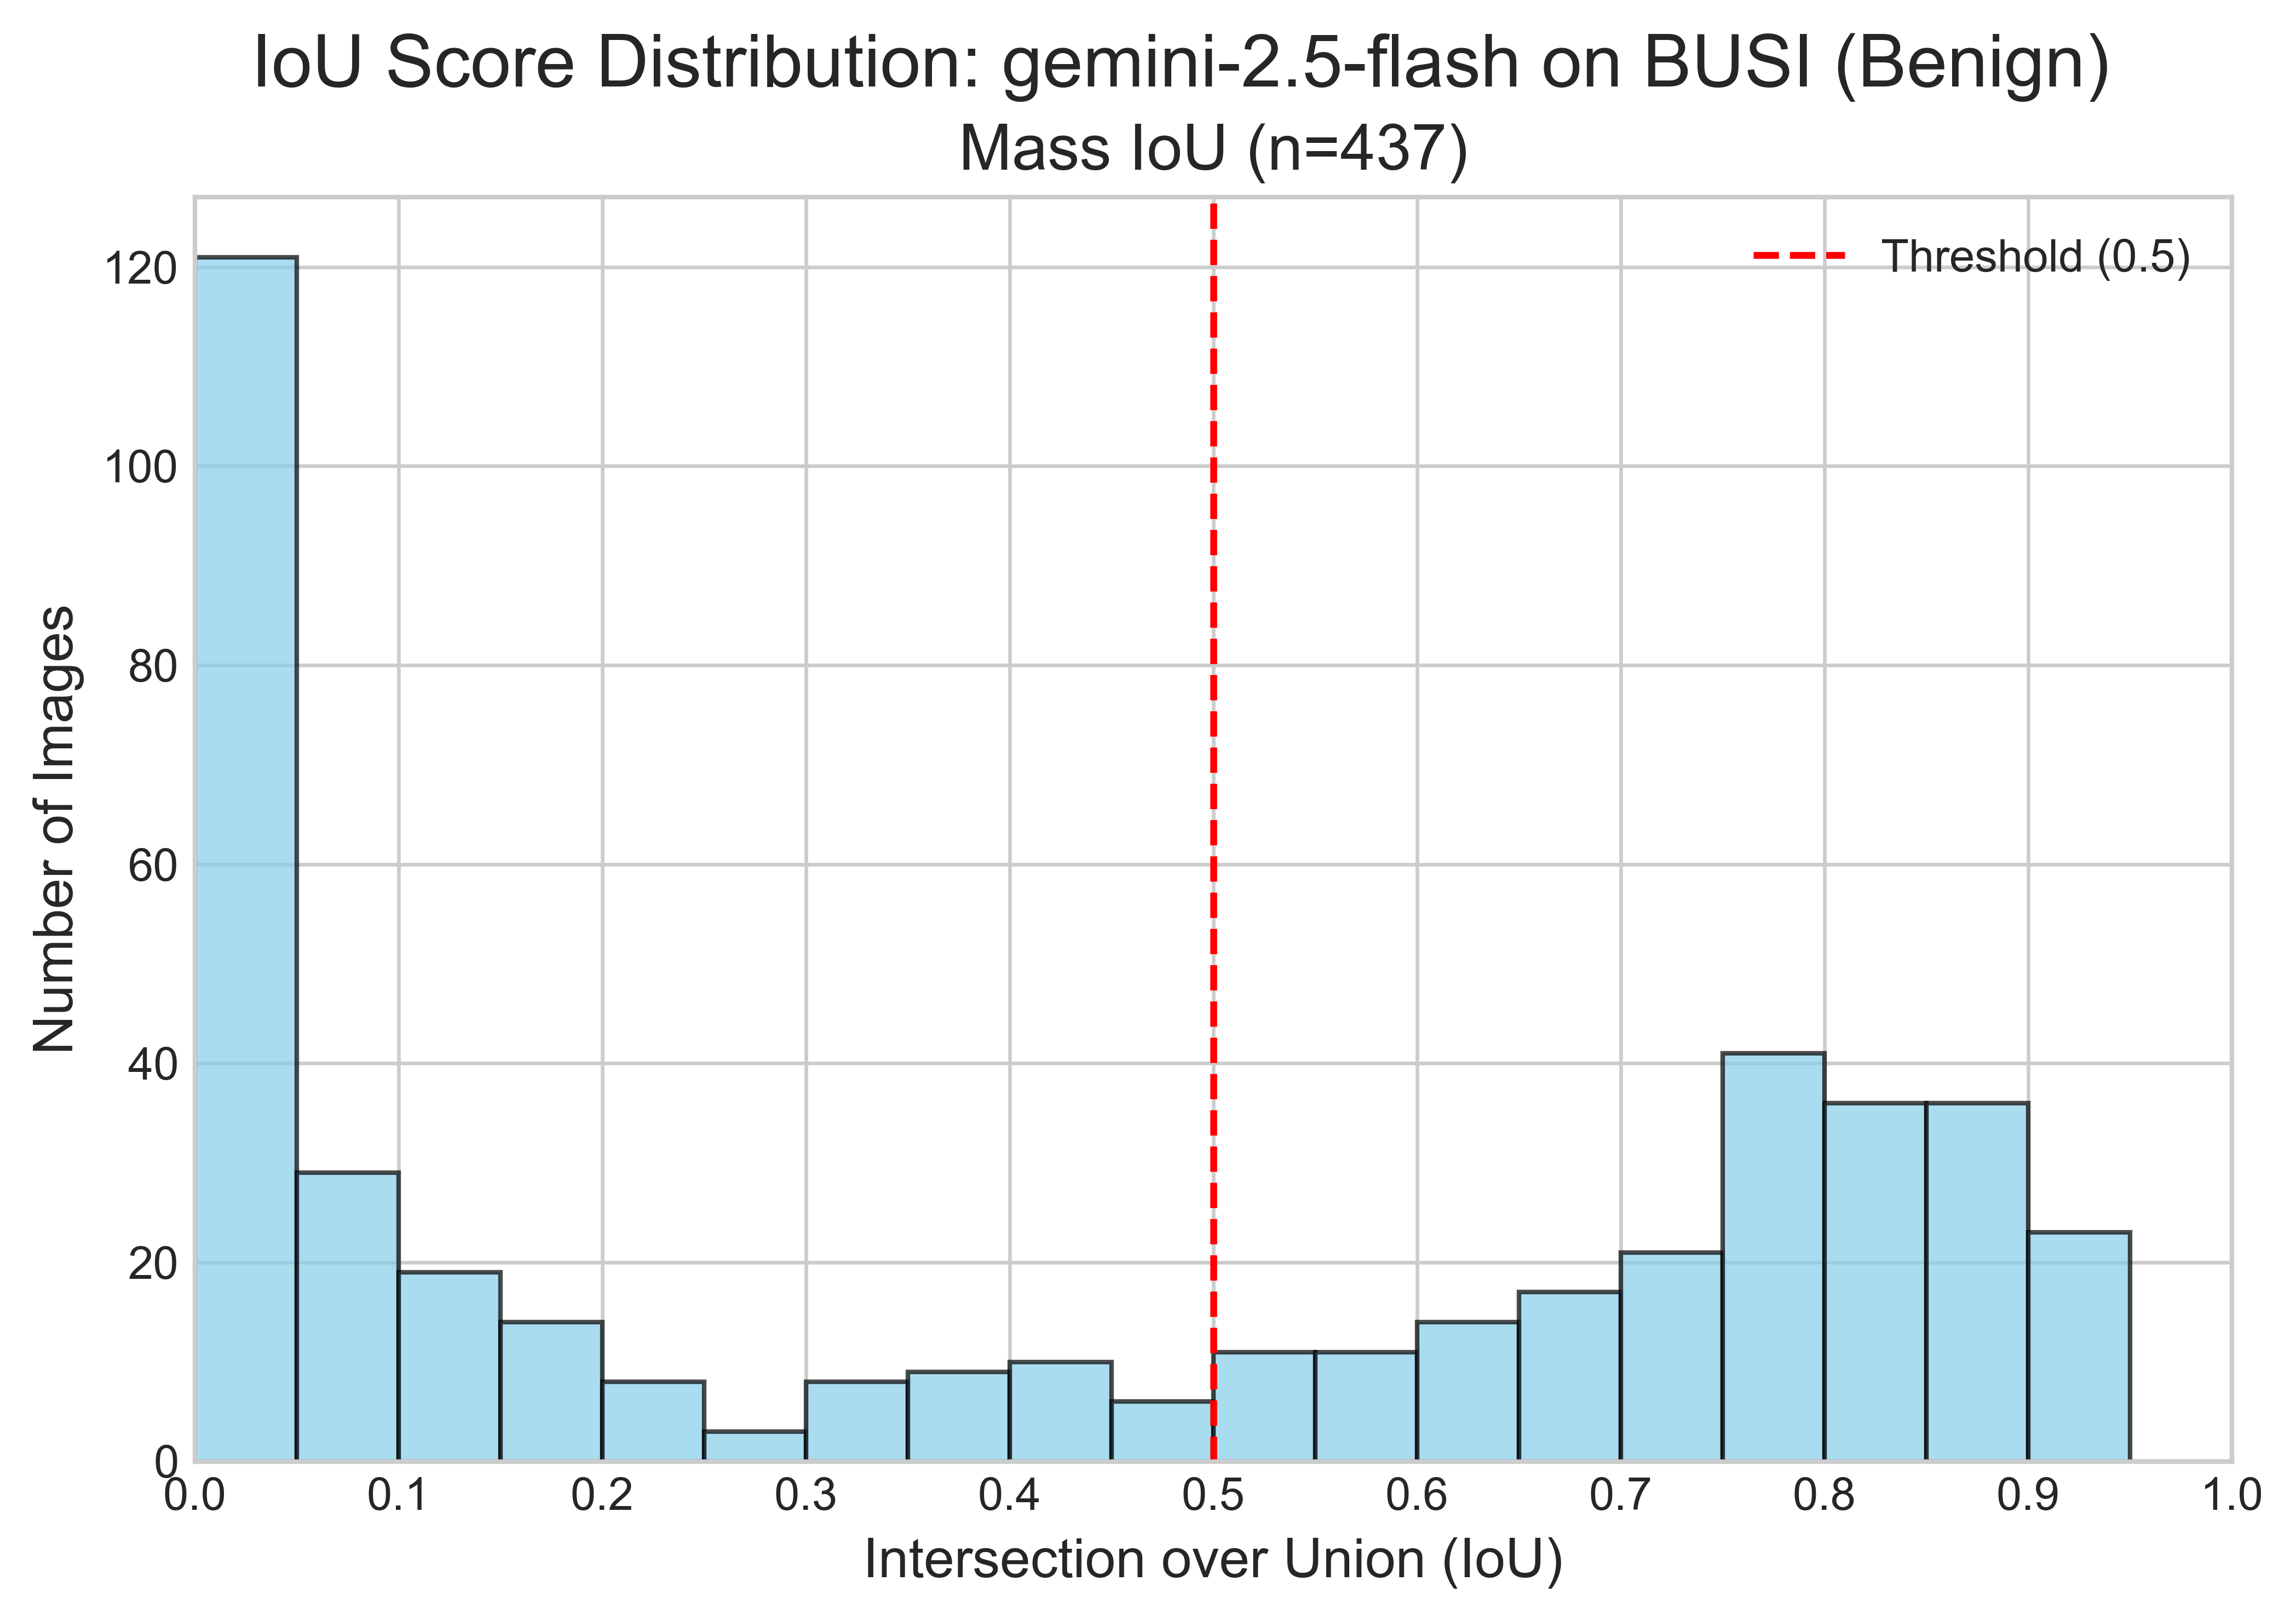

"\n✅ Evaluation complete. The report above summarizes the model's performance on the specified class of the BUSI dataset.\n"

In [ ]:
# %% [markdown]
"""
# 04 Model Evaluation · **BUSI Breast Mass Segmentation**

*Last sync 02 Aug 2025*

This notebook evaluates the performance of the `gemini_seg` function for segmenting breast
masses from the BUSI dataset. It systematically calculates and aggregates key
performance metrics by comparing the model's output against ground-truth data.

**Key Features (Adapted for BUSI):**
- **Class-Specific Evaluation:** A `TARGET_CLASS` variable toggles evaluation between "benign" and "malignant" subsets.
- **Core Performance Metrics:** Calculates Dice Score and Intersection over Union (IoU).
- **Configurable & Self-Contained:** Automatically generates a class-specific master image list.
- **Flexible Analysis:** A toggle (`EXCLUDE_LOW_IOU_FROM_STATS`) allows metrics and plots to be generated for either all images or only successful detections.
- **Robust Failure Analysis:** Categorizes and saves lists of failed images (JSON errors, false negatives, low IoU) for detailed review.
- **Bootstrapped Confidence Intervals:** An optional toggle (`ENABLE_BOOTSTRAPPING`) enables the calculation of 95% confidence intervals for all key metrics.
- **Publication-Ready Outputs:** Saves a detailed, class-specific JSON summary and a high-resolution (600 DPI) plot of the IoU distribution.
- **Robust API Handling:** Includes rate limiting, client-side request timeouts, and prediction caching.
"""

# %%
# ---------- Preamble & Setup ----------
import sys, logging, os, subprocess, importlib.util, json, io, random, base64, dataclasses, time
from datetime import datetime
from pathlib import Path
from typing import Tuple, List, Dict
from concurrent.futures import ThreadPoolExecutor, TimeoutError

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor, UnidentifiedImageError
from tqdm.notebook import tqdm
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Evaluation notebook start.")

# %%
# ---------- Ensure helper packages ----------
def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow", "google-genai", "pandas"):
    _ensure(extra)

# %%
# ---------- GenAI Client & Dataset Paths ----------
load_dotenv(find_dotenv(), override=False)

from google import genai
from google.genai.types import GenerateContentConfig, Part, ThinkingConfig

if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("GOOGLE_API_KEY not found. Ensure it is in your .env file.")

client = genai.Client()
logging.info("GenAI client initialized.")

# MODIFIED: Point to the BUSI dataset directory.
dataset_dir = Path("data/BUSI").expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("BUSI dataset found at %s", dataset_dir)


# %%
# ---------- CONFIGURATION: Set Target Class ----------
# MODIFIED: Toggle this variable to switch between 'benign' and 'malignant' datasets for evaluation.
TARGET_CLASS = "benign"  # Options: "benign", "malignant"
assert TARGET_CLASS in ["benign", "malignant"], "TARGET_CLASS must be 'benign' or 'malignant'."
logging.info("Selected target class for evaluation: %s", TARGET_CLASS)


# %% [markdown]
"""
### Core Functions (Adapted for Single-Class BUSI)

This section includes the necessary functions for segmentation and evaluation, adapted for the single-class breast mass task.

**Key Modifications:**
- **`PROMPT`:** Updated to request segmentation of "the breast mass."
- **`parse_ground_truth_mask`:** Adapted to parse the binary PNG masks from the BUSI dataset.
- **`gemini_seg`:** Retains its robust error handling and timeout features, now using PNG format.
"""

# %%
# ---------- Core Segmentation & Parsing Logic ----------

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def parse_json(json_output: str) -> str:
    """Cleans the model's JSON output by removing markdown fencing."""
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line.strip() == "```json":
            json_content = "\n".join(lines[i+1:])
            closing_fence_index = json_content.find("```")
            if closing_fence_index != -1:
                json_content = json_content[:closing_fence_index]
            return json_content.strip()
    return json_output.strip()

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> Tuple[List[SegmentationMask], bool]:
    """
    Parses the model's JSON output into a list of SegmentationMask objects.
    Returns the list of masks and a boolean indicating if JSON parsing was successful.
    """
    cleaned_json = parse_json(predicted_str)
    if not cleaned_json:
        logging.warning("Parsing model output resulted in an empty string.")
        return [], True # Technically not a JSON error, but an empty response.

    try:
        items = json.loads(cleaned_json)
        parse_success = True
    except json.JSONDecodeError as e:
        logging.error(f"Failed to decode JSON: {e}")
        logging.error(f"Problematic string after cleaning: {cleaned_json}")
        return [], False

    masks = []
    for item in items:
        try:
            abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
            abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
            abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
            abs_x1 = int(item["box_2d"][3] / 1000 * img_width)

            if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
                continue

            label = item["label"].lower() # Standardize label to lowercase
            png_b64_str = item["mask"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            partial_mask_img = Image.open(io.BytesIO(png_bytes))

            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            resized_mask = partial_mask_img.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
            full_mask_np = np.zeros((img_height, img_width), dtype=np.uint8)
            full_mask_np[abs_y0:abs_y1, abs_x0:abs_x1] = np.array(resized_mask)

            masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, full_mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in JSON response: {item}. Error: {e}")
            continue
    return masks, parse_success

def parse_ground_truth_mask(mask_path: Path) -> list[SegmentationMask]:
    """
    Parses a BUSI ground truth PNG file into a single SegmentationMask for the mass.
    The mask is a single-channel binary image (0 for background, 255 for mass).
    """
    try:
        mask_img = Image.open(mask_path).convert("L") # Ensure single channel grayscale
        mask_data = np.array(mask_img)
    except (FileNotFoundError, UnidentifiedImageError) as e:
        logging.error("Could not read ground truth mask file %s: %s", mask_path, e)
        return []

    binary_mask_data = mask_data > 127 # Create a boolean mask

    if not np.any(binary_mask_data):
        return []

    rows, cols = np.where(binary_mask_data)
    y0, y1 = rows.min(), rows.max()
    x0, x1 = cols.min(), cols.max()
    full_mask_np = binary_mask_data.astype(np.uint8) * 255
    # MODIFIED: The label is consistently "mass" for this single-class task.
    return [SegmentationMask(y0, x0, y1, x1, full_mask_np, "mass")]


# MODIFIED: Prompt updated for breast mass segmentation (generalized version).
PROMPT = (
    'Give the segmentation mask for the breast mass in this ultrasound image. '
    'Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key "box_2d", '
    'the segmentation mask in key "mask", and the text label in the key "label". '
    'Use a descriptive label like "mass".'
)

def gemini_seg(image_obj: Image.Image, model_name: str, thinking_budget: int) -> Tuple[List[SegmentationMask], float, bool]:
    """
    Sends a PIL Image object to Gemini and returns segmentation masks, with a client-side timeout.
    """
    original_width, original_height = image_obj.size
    
    img_for_api = image_obj.copy()
    max_dim = 1024
    if img_for_api.height > max_dim or img_for_api.width > max_dim:
        img_for_api.thumbnail((max_dim, max_dim))

    with io.BytesIO() as img_byte_arr:
        # MODIFIED: Save as PNG for BUSI dataset
        img_for_api.save(img_byte_arr, format='PNG')
        img_bytes = img_byte_arr.getvalue()

    gen_config = GenerateContentConfig(
        thinking_config=ThinkingConfig(thinking_budget=thinking_budget),
        temperature=0.5
    )
    # MODIFIED: Use image/png mime type
    image_part = Part.from_bytes(data=img_bytes, mime_type='image/png')
    text_part = Part(text=PROMPT)
    
    def do_api_call():
        return client.models.generate_content(
            model=model_name, contents=[image_part, text_part], config=gen_config
        )

    start_time = datetime.now()
    try:
        if ENABLE_REQUEST_TIMEOUT:
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(do_api_call)
                response = future.result(timeout=REQUEST_TIMEOUT_SEC)
        else:
            response = do_api_call()
        
        latency = (datetime.now() - start_time).total_seconds()
        masks, parse_success = parse_segmentation_masks(
            response.text, img_height=original_height, img_width=original_width
        )
        return masks, latency, parse_success

    except TimeoutError:
        logging.error(f"API call timed out after {REQUEST_TIMEOUT_SEC} seconds.")
        return [], 0.0, False
    except Exception as e:
        logging.error(f"An error occurred during the gemini_seg function.", exc_info=True)
        return [], 0.0, False

def save_prediction_details(masks: List[SegmentationMask], output_path: Path):
    """Saves the detailed contents of SegmentationMask objects to a JSON file."""
    if not masks:
        output_path.write_text(json.dumps([]))
        return

    results_to_save = []
    for mask_obj in masks:
        pil_img = Image.fromarray(mask_obj.mask)
        with io.BytesIO() as buffer:
            pil_img.save(buffer, format="PNG")
            png_bytes = buffer.getvalue()
        b64_string = base64.b64encode(png_bytes).decode('utf-8')
        results_to_save.append({
            "label": mask_obj.label,
            "box_2d_absolute": [mask_obj.y0, mask_obj.x0, mask_obj.y1, mask_obj.x1],
            "mask_b64": f"data:image/png;base64,{b64_string}"
        })
    with open(output_path, 'w') as f:
        json.dump(results_to_save, f, indent=2)

# %% [markdown]
"""
### Metric Calculation Utilities

These functions implement the formulas for Intersection over Union (IoU), the Dice Coefficient, and bootstrapping for confidence intervals.
"""

# %%
# ---------- Metric Calculation Functions ----------

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0: return 1.0
    return np.sum(intersection) / np.sum(union)

def calculate_dice(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates the Dice Coefficient for boolean masks."""
    intersection = np.sum(np.logical_and(y_true, y_pred))
    denominator = np.sum(y_true) + np.sum(y_pred)
    if denominator == 0: return 1.0
    return (2. * intersection) / (denominator + 1e-7)

def calculate_bootstrap_ci(data: List[float], n_resamples: int = 1000) -> Tuple[float, float]:
    """Calculates the 95% confidence interval for a list of numbers using bootstrapping."""
    if not data or len(data) < 2: return 0.0, 0.0
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_resamples)]
    return np.percentile(bootstrapped_means, 2.5), np.percentile(bootstrapped_means, 97.5)

# %% [markdown]
"""
### Evaluation Execution

This is the main loop of the notebook. It will:
1.  Generate a master list of valid image-mask pairs from the specified `TARGET_CLASS` directory.
2.  Randomly sample a specified number of images (`NUM_IMAGES_TO_TEST`).
3.  Iterate through each image, calling `gemini_seg` and parsing the ground truth.
4.  Compare the predicted mask to the ground truth mask.
5.  Calculate IoU and Dice for each image and store the results.
6.  Categorize and log any failures (e.g., parsing errors, missed detections).
"""

# %%
# ---------- Main Evaluation Loop ----------

# <<< --- PARAMETERS TO CONTROL THE EVALUATION --- >>>
MODEL_NAME = "gemini-2.5-flash-lite"
THINKING_BUDGET = 0
NUM_IMAGES_TO_TEST = 0 # Set to None or 0 to test all images
SAVE_PREDICTIONS = True
ENABLE_BOOTSTRAPPING = True
ENABLE_RATE_LIMITING = False
RATE_LIMIT_DELAY_SEC = 9
ENABLE_REQUEST_TIMEOUT = True
REQUEST_TIMEOUT_SEC = 300
LOW_IOU_THRESHOLD = 0.5
EXCLUDE_LOW_IOU_FROM_STATS = True # If True, stats only use runs with IoU >= threshold. If False, all runs are used. Plots always plot all runs.

model_name_safe = MODEL_NAME.replace("/", "_")
logging.info(f"Starting evaluation run for model: {MODEL_NAME} on BUSI dataset (Class: {TARGET_CLASS}).")

# --- Define direct path to class subdirectory ---
data_subdir = dataset_dir / TARGET_CLASS

# --- Generate Master Image List if it Doesn't Exist ---
master_list_path = dataset_dir / f"master_imagelist_busi_{TARGET_CLASS}.txt"
if not master_list_path.exists():
    logging.info(f"Master image list not found for class '{TARGET_CLASS}'. Generating it now at: {master_list_path}")
    all_files = sorted(data_subdir.glob("*.png"))
    valid_pairs = []
    for img_path in all_files:
        if "_mask" in img_path.name:
            continue
        mask_path = img_path.with_name(f"{img_path.stem}_mask.png")
        if mask_path.exists():
            valid_pairs.append(img_path)
    
    if not valid_pairs:
        raise RuntimeError(f"No valid image-mask pairs found for class '{TARGET_CLASS}' in {data_subdir}.")
    master_list_path.write_text("\n".join(str(p) for p in valid_pairs))
    logging.info(f"Successfully generated master list for '{TARGET_CLASS}' with {len(valid_pairs)} images.")

# --- Create Model-Specific Predictions Directory ---
if SAVE_PREDICTIONS:
    predictions_dir = dataset_dir / f"predictions_{TARGET_CLASS}_{model_name_safe}"
    predictions_dir.mkdir(exist_ok=True)
    logging.info(f"Detailed predictions will be saved to: {predictions_dir}")

# --- Load and Prepare Evaluation Set ---
with open(master_list_path, 'r') as f:
    all_available_paths = [Path(line.strip()) for line in f.readlines()]
num_available = len(all_available_paths)
random.seed(42)
random.shuffle(all_available_paths)

if NUM_IMAGES_TO_TEST is None or NUM_IMAGES_TO_TEST <= 0:
    images_to_evaluate = all_available_paths
else:
    images_to_evaluate = all_available_paths[:min(NUM_IMAGES_TO_TEST, num_available)]
logging.info(f"Loaded {num_available} total images for class '{TARGET_CLASS}'. Will evaluate a sample of {len(images_to_evaluate)}.")

# --- Initialize storage for results and failures ---
evaluation_results = []
json_failures, fn_mass_failures, low_iou_mass_failures = [], [], []

for img_path in tqdm(images_to_evaluate, desc=f"Evaluating {TARGET_CLASS} - {model_name_safe}"):
    try:
        logging.info(f"Processing: {img_path.name}")
        original_image = Image.open(img_path)

        predicted_masks, latency, parse_success = gemini_seg(original_image, MODEL_NAME, THINKING_BUDGET)

        if SAVE_PREDICTIONS:
            prediction_output_path = predictions_dir / f"{img_path.stem}.json"
            save_prediction_details(predicted_masks, prediction_output_path)

        # MODIFIED: Directly construct the mask path from the image path.
        mask_path = img_path.with_name(f"{img_path.stem}_mask.png")
        if not mask_path.exists():
            logging.warning(f"Could not find matching mask for image {img_path.name}. Skipping.")
            continue
            
        gt_masks = parse_ground_truth_mask(mask_path)
        
        # --- Get the single ground truth mask and the first predicted mask ---
        gt_mask_np = gt_masks[0].mask if gt_masks else np.zeros((original_image.height, original_image.width), dtype=np.uint8)
        pred_mask_np = predicted_masks[0].mask if predicted_masks else np.zeros_like(gt_mask_np)

        # --- Calculate metrics ---
        iou_mass = calculate_iou(gt_mask_np > 127, pred_mask_np > 127)
        dice_mass = calculate_dice(gt_mask_np > 127, pred_mask_np > 127)

        # --- Categorize Failures ---
        if not parse_success:
            json_failures.append(img_path.name)
        elif not predicted_masks:
            fn_mass_failures.append(img_path.name)
        elif iou_mass < LOW_IOU_THRESHOLD:
            low_iou_mass_failures.append(img_path.name)

        evaluation_results.append({
            "image_path": img_path.name, "latency_sec": latency, "parse_success": parse_success,
            "iou_mass": iou_mass, "dice_mass": dice_mass,
        })

    except Exception as e:
        logging.error(f"An unexpected error occurred while processing {img_path.name}", exc_info=True)
        evaluation_results.append({
            "image_path": img_path.name, "latency_sec": 0, "parse_success": False,
            "iou_mass": 0, "dice_mass": 0,
        })
    
    if ENABLE_RATE_LIMITING:
        time.sleep(RATE_LIMIT_DELAY_SEC)

logging.info("Evaluation loop complete.")

# %% [markdown]
"""
### Failure Analysis & Reporting

This section saves the lists of failed images to model- and class-specific text files for easier manual review.
"""

# %%
# ---------- Save Failure Lists to Files ----------
def save_failure_list(failure_list: List[str], failure_type: str, model_name: str, target_class: str):
    """Saves a list of failed image names to a text file."""
    if failure_list:
        failure_path = dataset_dir / f"failures_{failure_type}_{target_class}_{model_name}.txt"
        logging.info(f"Saving {len(failure_list)} {failure_type} failures to {failure_path}")
        failure_path.write_text("\n".join(failure_list))

save_failure_list(json_failures, "json", model_name_safe, TARGET_CLASS)
save_failure_list(fn_mass_failures, "fn_mass", model_name_safe, TARGET_CLASS)
save_failure_list(low_iou_mass_failures, "low_iou_mass", model_name_safe, TARGET_CLASS)

# %% [markdown]
"""
### Results Summary

The following report aggregates the results from the evaluation run and saves a copy to a model- and class-specific `evaluation_summary_busi_...json` file.
"""

# %%
# ---------- Aggregate, Display, and Save Results ----------

if evaluation_results:
    df = pd.DataFrame(evaluation_results)

    # --- Determine which data to use for stats based on the toggle ---
    if EXCLUDE_LOW_IOU_FROM_STATS:
        logging.info(f"Excluding cases with IoU < {LOW_IOU_THRESHOLD} from stats.")
        runs_for_stats = df[df['iou_mass'] >= LOW_IOU_THRESHOLD]
    else:
        logging.info("Including all cases (even IoU=0) in stats.")
        runs_for_stats = df

    # --- Performance Metrics ---
    mean_iou_mass = runs_for_stats['iou_mass'].mean()
    mean_dice_mass = runs_for_stats['dice_mass'].mean()

    # --- Operational Metrics ---
    valid_latencies = df[df['latency_sec'] > 0]['latency_sec']
    mean_latency = valid_latencies.mean() if not valid_latencies.empty else 0
    total_runs = len(df)
    parse_success_rate = df['parse_success'].mean() * 100

    # --- Confidence Intervals (calculated on the selected data) ---
    iou_mass_ci, dice_mass_ci, latency_ci = [(0,0)]*3
    if ENABLE_BOOTSTRAPPING and not runs_for_stats.empty:
        logging.info("Calculating 95%% CIs with 1000-fold bootstrapping...")
        iou_mass_ci = calculate_bootstrap_ci(runs_for_stats['iou_mass'].tolist())
        dice_mass_ci = calculate_bootstrap_ci(runs_for_stats['dice_mass'].tolist())
        latency_ci = calculate_bootstrap_ci(valid_latencies.tolist())
        logging.info("CI calculation complete.")

    print("---" * 15)
    print(f"       GenAI Segmentation Evaluation Report: {MODEL_NAME} on BUSI ({TARGET_CLASS.capitalize()})")
    print("---" * 15)
    print(f"Total Images Evaluated: {total_runs}")
    print(f"IoU Threshold for Success: {LOW_IOU_THRESHOLD}")
    print(f"Exclude Low IoU from Stats: {EXCLUDE_LOW_IOU_FROM_STATS}")
    
    print("\n--- Performance Metrics ---")
    print(f"Mean IoU (Mass):      {mean_iou_mass:.4f} (95% CI: {iou_mass_ci[0]:.4f} - {iou_mass_ci[1]:.4f}) on {len(runs_for_stats)} images")
    print(f"Mean Dice (Mass):     {mean_dice_mass:.4f} (95% CI: {dice_mass_ci[0]:.4f} - {dice_mass_ci[1]:.4f})")
    
    print("\n--- Operational Metrics ---")
    print(f"Mean API Latency:     {mean_latency:.2f}s (95% CI: {latency_ci[0]:.2f}s - {latency_ci[1]:.2f}s)")
    print(f"JSON Parse Success:   {parse_success_rate:.1f}%")

    print("\n--- Failure Analysis (based on full dataset) ---")
    print(f"JSON Failures:              {len(json_failures)} ({len(json_failures)/total_runs:.1%})")
    print(f"False Negatives (Mass):     {len(fn_mass_failures)} ({len(fn_mass_failures)/total_runs:.1%})")
    print(f"Low IoU (Mass):             {len(low_iou_mass_failures)} ({len(low_iou_mass_failures)/total_runs:.1%})")
    print("---" * 15)

    # --- Save Summary JSON ---
    summary_data = {
        "run_timestamp": datetime.now().isoformat(),
        "dataset": "BUSI",
        "target_class": TARGET_CLASS,
        "total_images_evaluated": total_runs,
        "settings": { 
            "model_name": MODEL_NAME, 
            "thinking_budget": THINKING_BUDGET, 
            "low_iou_threshold": LOW_IOU_THRESHOLD,
            "exclude_low_iou_from_stats": EXCLUDE_LOW_IOU_FROM_STATS,
        },
        "performance_metrics": {
            "mean_iou_mass": mean_iou_mass, "mean_iou_mass_95_ci": iou_mass_ci,
            "mean_dice_mass": mean_dice_mass, "mean_dice_mass_95_ci": dice_mass_ci,
        },
        "operational_metrics": {
            "mean_latency_sec": mean_latency, "mean_latency_95_ci": latency_ci,
            "json_parse_success_rate_percent": parse_success_rate,
        },
        "failure_counts": {
            "json_parsing": len(json_failures),
            "false_negative_mass": len(fn_mass_failures),
            "low_iou_mass": len(low_iou_mass_failures),
        }
    }
    summary_path = dataset_dir / f"evaluation_summary_busi_{TARGET_CLASS}_{model_name_safe}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=4)
    logging.info(f"Saved evaluation summary to {summary_path}")

    # --- Visualize and save the distribution of IoU scores ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=600)
    fig.suptitle(f'IoU Score Distribution: {MODEL_NAME} on BUSI ({TARGET_CLASS.capitalize()})', fontsize=16)

    ax.hist(df['iou_mass'], bins=20, range=(0,1), edgecolor='black', alpha=0.7, color='skyblue')
    ax.set_title(f'Mass IoU (n={len(df)})', fontsize=14)
    ax.set_xlabel('Intersection over Union (IoU)', fontsize=12)
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.axvline(LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({LOW_IOU_THRESHOLD})')
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

    plot_path = dataset_dir / f"iou_distribution_busi_{TARGET_CLASS}_{model_name_safe}.png"
    plt.savefig(plot_path, bbox_inches='tight')
    logging.info(f"Saved high-resolution IoU plot to {plot_path}")
    plt.show()
else:
    print("No evaluation results were generated.")

# %% [markdown]
"""
✅ Evaluation complete. The report above summarizes the model's performance on the specified class of the BUSI dataset.
"""


# Case Plotting

2025-08-01 23:55:58 — INFO — ISIC 2017 dataset found at D:\Projects\gemini_image_segmentation\data\ISIC_2017_Part1
2025-08-01 23:55:58 — INFO — IMAGE_TO_VISUALIZE not set. Searching for a complete case for model 'gemini-2.5-flash'...
2025-08-01 23:55:58 — INFO — Found complete case: 'ISIC_0000000.jpg'. Visualizing...
2025-08-01 23:55:58 — INFO — Loading original image: ISIC_0000000.jpg
2025-08-01 23:55:58 — INFO — Loading ground truth: ISIC_0000000_Segmentation.png
2025-08-01 23:55:58 — INFO — Loading prediction for model 'gemini-2.5-flash' from cache: ISIC_0000000.json


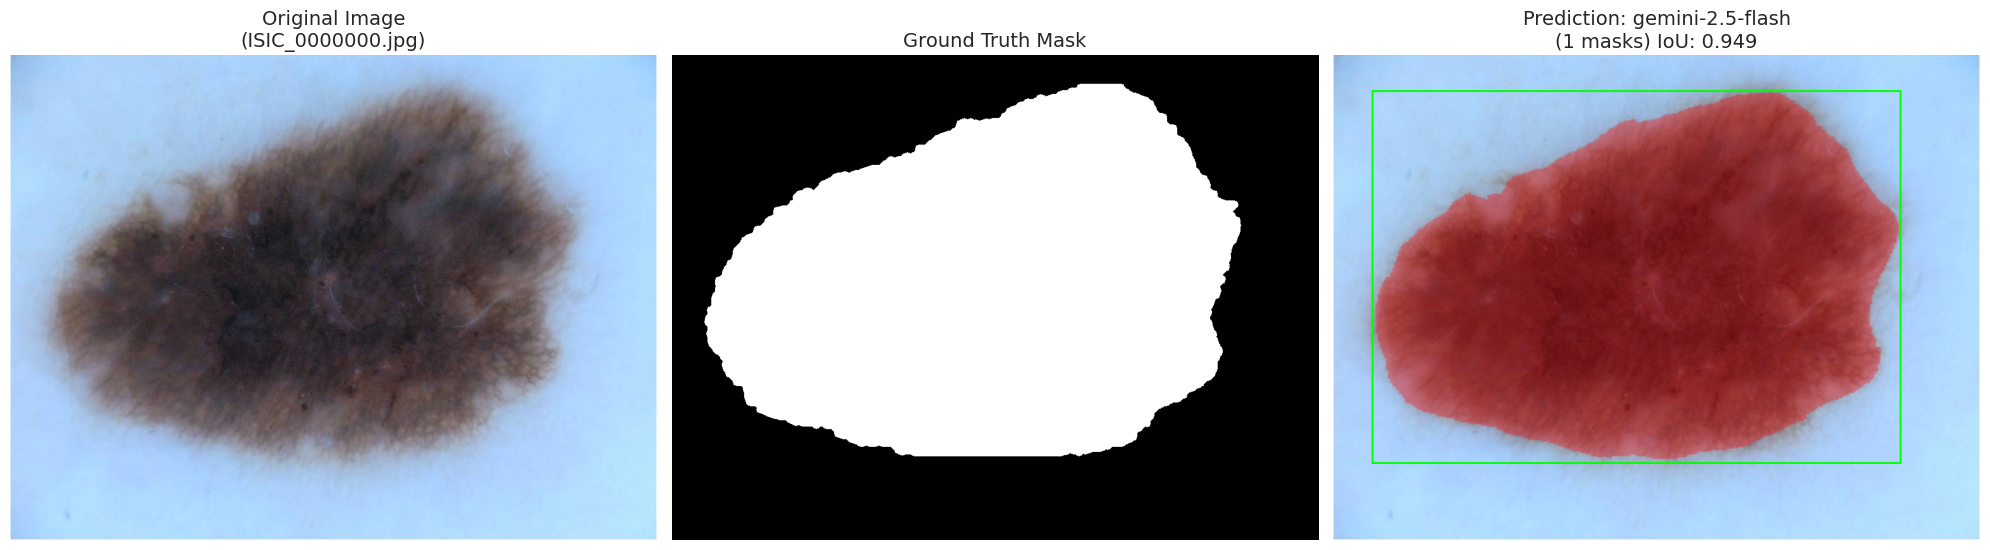

In [ ]:
# %% [markdown]
"""
# 05 Qualitative Analysis (BUSI)

*Last sync 02 Aug 2025*

This notebook provides tools to perform a qualitative check on the model's output from a previous evaluation run on the BUSI dataset. It loads a cached prediction from the model- and class-specific `predictions_<class>_<model_name>/` directory and displays a three-panel comparison for any given image.

**Instructions:**
- Ensure you have run the `04_Model_Evaluation_BUSI` notebook first with `SAVE_PREDICTIONS = True`.
- Set the `TARGET_CLASS` and `MODEL_TO_VISUALIZE` variables in the last cell.
- To visualize a specific image, set the `IMAGE_TO_VISUALIZE` variable to the desired filename (e.g., `benign (1).png`).
- If you leave `IMAGE_TO_VISUALIZE` as `None`, the script will automatically find and display the first available case.
"""

# %%
# ---------- Preamble & Setup ----------
import os, json, base64, dataclasses, logging, io
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, UnidentifiedImageError
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

# %%
# ---------- Dataset Path & Helper Functions ----------
# MODIFIED: Point to the BUSI dataset directory.
dataset_dir = Path("data/BUSI").expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("BUSI dataset found at %s", dataset_dir)


@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    """A dataclass to hold a single segmentation mask's data."""
    y0: int
    x0: int
    y1: int
    x1: int
    mask: np.ndarray # Full-size mask [img_height, img_width] with values 0..255
    label: str

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0:
        return 1.0 # If both masks are empty, it's a perfect match.
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def load_prediction_from_cache(prediction_path: Path) -> List[SegmentationMask]:
    """Loads and parses a cached prediction JSON file into SegmentationMask objects."""
    if not prediction_path.exists():
        logging.error(f"Prediction cache file not found: {prediction_path}")
        return []
    
    with open(prediction_path, 'r') as f:
        try:
            items = json.load(f)
        except json.JSONDecodeError:
            logging.error(f"Could not decode JSON from cached file: {prediction_path}")
            return []

    masks = []
    for item in items:
        try:
            y0, x0, y1, x1 = item["box_2d_absolute"]
            label = item["label"]
            
            png_b64_str = item["mask_b64"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            mask_img = Image.open(io.BytesIO(png_bytes))
            mask_np = np.array(mask_img)

            masks.append(SegmentationMask(y0, x0, y1, x1, mask_np, label))
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in cached prediction: {item}. Error: {e}")
            continue
    return masks

def find_complete_case(model_name: str, target_class: str) -> str | None:
    """
    Scans a model's predictions directory and finds the first case that has a
    corresponding original image in the BUSI dataset structure.
    """
    model_name_safe = model_name.replace("/", "_")
    predictions_dir = dataset_dir / f"predictions_{target_class}_{model_name_safe}"
    images_dir = dataset_dir / target_class
    
    if not predictions_dir.exists():
        logging.error(f"Predictions directory not found for model '{model_name}' and class '{target_class}': {predictions_dir}")
        return None

    for pred_file in sorted(predictions_dir.glob("*.json")):
        # BUSI images are PNGs
        image_file = images_dir / f"{pred_file.stem}.png"

        if image_file.exists():
            return image_file.name
            
    return None

def visualize_single_case(image_name: str, model_name: str, target_class: str):
    """
    Generates and displays a 3-panel plot comparing the original image,
    ground truth mask, and the model's predicted mask overlay from cached files
    for the BUSI dataset.
    """
    model_name_safe = model_name.replace("/", "_")
    image_path = dataset_dir / target_class / image_name
    
    # MODIFIED: Construct the ground truth mask path using the BUSI naming convention.
    gt_mask_name = f"{Path(image_name).stem}_mask.png"
    gt_mask_path = dataset_dir / target_class / gt_mask_name
    
    prediction_path = dataset_dir / f"predictions_{target_class}_{model_name_safe}" / f"{Path(image_name).stem}.json"
    
    if not image_path.exists():
        logging.error(f"Image file does not exist: {image_path}")
        return
    if not prediction_path.exists():
        logging.error(f"Prediction file does not exist for model '{model_name}' and class '{target_class}': {prediction_path}")
        return

    logging.info(f"Loading original image: {image_path.name}")
    original_image = Image.open(image_path).convert("RGBA")
    
    logging.info(f"Loading ground truth: {gt_mask_path.name}")
    if gt_mask_path.exists():
        gt_mask_img = Image.open(gt_mask_path).convert("L")
        gt_mask_np = np.array(gt_mask_img) > 127
    else:
        logging.warning(f"Ground truth mask not found for {image_path.name}")
        gt_mask_img = Image.new("L", original_image.size, 0)
        gt_mask_np = np.zeros(original_image.size, dtype=bool)

    logging.info(f"Loading prediction for model '{model_name}' from cache: {prediction_path.name}")
    predicted_masks = load_prediction_from_cache(prediction_path)

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    plt.style.use('default')

    axes[0].imshow(original_image)
    axes[0].set_title(f"Original Image ({target_class.capitalize()})\n({image_name})", fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(gt_mask_img, cmap='gray')
    axes[1].set_title("Ground Truth Mask", fontsize=14)
    axes[1].axis('off')

    overlay_image = original_image.copy()
    title = f"Prediction: {model_name}"
    if not predicted_masks:
        title = f"Prediction: {model_name}\n(No Mask Found)"
    else:
        # For single-class mass segmentation, combine all predicted masks into one.
        combined_pred_mask_np = np.zeros_like(gt_mask_np, dtype=bool)
        for seg_mask in predicted_masks:
            pred_mask_binary = seg_mask.mask > 127
            combined_pred_mask_np = np.logical_or(combined_pred_mask_np, pred_mask_binary)
        
        iou_val = calculate_iou(gt_mask_np, combined_pred_mask_np)
        title = f"Prediction: {model_name}\n({len(predicted_masks)} masks) IoU: {iou_val:.3f}"

        mask_color = (255, 0, 0, 90) # Semi-transparent red for mask
        box_color = (0, 255, 0)      # Bright green for bounding box
        
        for mask_obj in predicted_masks:
            mask_img_pil = Image.fromarray(mask_obj.mask).convert("L")
            colored_mask = Image.new("RGBA", original_image.size)
            colored_mask.paste(mask_color, mask=mask_img_pil)
            overlay_image = Image.alpha_composite(overlay_image, colored_mask)
            draw = ImageDraw.Draw(overlay_image)
            draw.rectangle([mask_obj.x0, mask_obj.y0, mask_obj.x1, mask_obj.y1], outline=box_color, width=3)

    axes[2].imshow(overlay_image)
    axes[2].set_title(title, fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# %% [markdown]
"""
### Visualize a Specific Image

To use this notebook, modify the variables below.
"""

# %%
# ---------- Specify Model and Image, then Run Visualization ----------

# <<< --- REQUIRED: Set the model name you want to visualize --- >>>
MODEL_TO_VISUALIZE = "gemini-2.5-flash"

# <<< --- REQUIRED: Set the class you want to visualize --- >>>
TARGET_CLASS = "benign" # Options: "benign", "malignant"

# <<< --- OPTIONAL: Set a specific filename to visualize --- >>>
# If you leave this as None, the script will automatically find the first
# available image for the specified model and class.
IMAGE_TO_VISUALIZE = None # e.g., "benign (1).png"

# --- Find and Visualize a Case ---
if not IMAGE_TO_VISUALIZE:
    logging.info(f"IMAGE_TO_VISUALIZE not set. Searching for a complete case for model '{MODEL_TO_VISUALIZE}' and class '{TARGET_CLASS}'...")
    IMAGE_TO_VISUALIZE = find_complete_case(MODEL_TO_VISUALIZE, TARGET_CLASS)
    if IMAGE_TO_VISUALIZE:
        logging.info(f"Found complete case: '{IMAGE_TO_VISUALIZE}'. Visualizing...")
    else:
        logging.error(f"Could not find any complete case for model '{MODEL_TO_VISUALIZE}' and class '{TARGET_CLASS}'.")
        logging.error("Please ensure you have run the `04_Model_Evaluation_BUSI` notebook for this model and class.")

if IMAGE_TO_VISUALIZE:
    # Check if the image exists in the correct class subfolder
    if not (dataset_dir / TARGET_CLASS / IMAGE_TO_VISUALIZE).exists():
        logging.error(f"The specified or found image '{IMAGE_TO_VISUALIZE}' does not exist in the '{TARGET_CLASS}' directory.")
    else:
        visualize_single_case(IMAGE_TO_VISUALIZE, MODEL_TO_VISUALIZE, TARGET_CLASS)


# Performance Metrics Re-Evaluation

TODO: Not confirmed to be working yet

2025-08-01 15:04:37 — INFO — Re-analysis notebook start.
2025-08-01 15:04:37 — INFO — Installing python-dotenv (missing)
2025-08-01 15:04:38 — INFO — Installing Pillow (missing)
2025-08-01 15:04:39 — INFO — REFUGE2 dataset found at D:\Projects\gemini_image_segmentation\data\REFUGE2
2025-08-01 15:04:39 — INFO — Found 1200 cached predictions for model 'gemini-2.5-flash-lite'.
2025-08-01 15:04:39 — INFO — Starting re-analysis with up to 12 threads.


Re-analyzing gemini-2.5-flash-lite:   0%|          | 0/1200 [00:00<?, ?it/s]

2025-08-01 15:05:57 — INFO — Excluding cases with IoU < 0.5 from stats calculations.
2025-08-01 15:05:57 — INFO — Saved re-analysis summary to D:\Projects\gemini_image_segmentation\data\REFUGE2\reanalysis_summary_gemini-2.5-flash-lite_thresh_0.5.json


---------------------------------------------
       Re-Analysis Report: gemini-2.5-flash-lite on REFUGE2
---------------------------------------------
Total Cached Predictions Analyzed: 1200
New IoU Threshold for Success:     0.5
Excluding Low IoU from Stats:    True

--- Performance Metrics ---
Mean IoU (Disc):      0.6694 (95% CI: 0.6587 - 0.6798) on 342 images
Mean IoU (Cup):       0.6178 (95% CI: 0.5998 - 0.6388) on 77 images
Mean Dice (Disc):     0.7974 (95% CI: 0.7895 - 0.8055)
Mean Dice (Cup):      0.7605 (95% CI: 0.7466 - 0.7751)

--- Clinical Metric ---
vCDR MAE:             0.2259 (95% CI: 0.2172 - 0.2341)

--- Failure Analysis (New Threshold) ---
False Negatives (Disc / Cup): 11 (0.9%) / 444 (37.0%)
Low IoU Failures (Disc / Cup): 847 (70.6%) / 679 (56.6%)
---------------------------------------------


2025-08-01 15:05:59 — INFO — Saved re-analysis IoU plot to D:\Projects\gemini_image_segmentation\data\REFUGE2\reanalysis_iou_dist_gemini-2.5-flash-lite_thresh_0.5.png


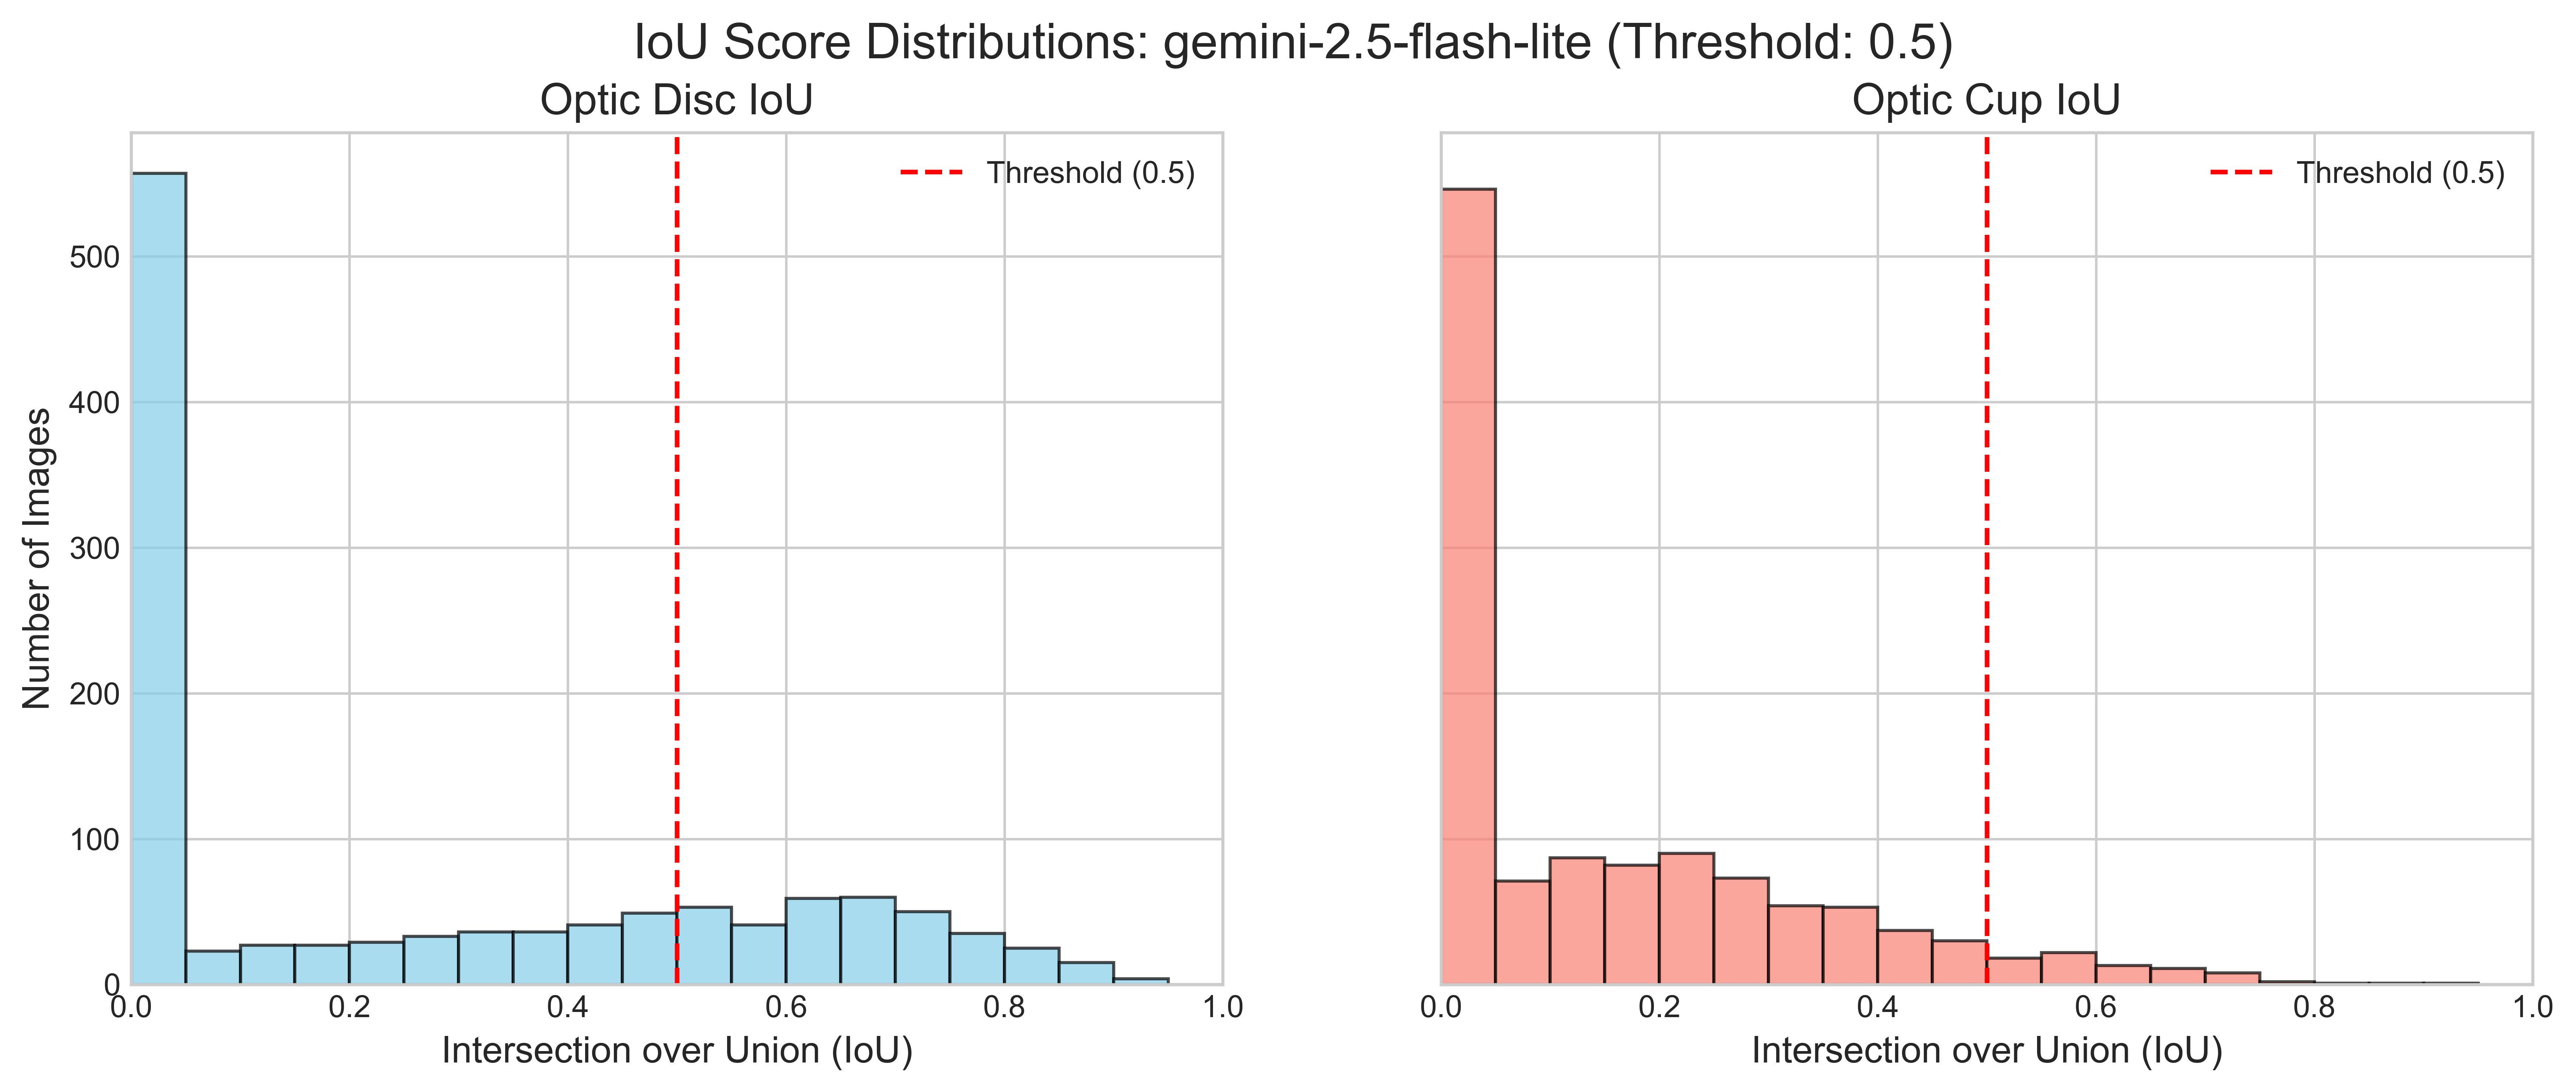

"\n✅ Re-analysis complete. The report above summarizes the model's performance using the new threshold.\n"

In [ ]:
# %% [markdown]
"""
# 06 Skin Lesion Results Re-Analysis Tool (Multithreaded)

*Last sync 01 Aug 2025*

This notebook re-calculates and re-plots evaluation metrics from a completed run's
cached predictions for the ISIC 2017 skin lesion segmentation task. It uses
multithreading to accelerate the processing of cached files.

**Instructions:**
1.  Ensure you have run the `04_Model_Evaluation_ISIC_2017` notebook with
    `SAVE_PREDICTIONS = True`.
2.  Set the `MODEL_TO_ANALYZE` variable below to the model you want to inspect.
3.  Set the `NEW_LOW_IOU_THRESHOLD` to the desired value for defining a "successful" detection.
4.  Use the `EXCLUDE_LOW_IOU_FROM_STATS` toggle to control the analysis behavior:
    - `True`: (Default) Excludes low-IoU cases from summary statistics (mean, CI).
      The plot will still show all cases but with a red threshold line.
    - `False`: Includes all cases (even IoU=0) in summary statistics.
      This gives a view of performance across the entire dataset.
"""

# %%
# ---------- Preamble & Setup ----------
import sys, logging, os, subprocess, importlib.util, json, io, base64, dataclasses
from datetime import datetime
from pathlib import Path
from typing import Tuple, List, Optional, Dict
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
from dotenv import load_dotenv, find_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.info("Re-analysis notebook start.")

# %%
# ---------- Ensure helper packages ----------
def _ensure(pkg: str):
    """Checks if a package is installed and installs it if not."""
    if importlib.util.find_spec(pkg) is None:
        logging.info("Installing %s (missing)", pkg)
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

for extra in ("python-dotenv", "tqdm", "matplotlib", "numpy", "Pillow", "pandas"):
    _ensure(extra)

# %%
# ---------- Dataset Path & Helper Functions ----------
# MODIFIED: Point to the ISIC 2017 dataset directory.
dataset_dir = Path("data/ISIC_2017_Part1").expanduser().resolve()
if not dataset_dir.is_dir():
    raise FileNotFoundError(f"Dataset directory not found at {dataset_dir}.")
logging.info("ISIC 2017 dataset found at %s", dataset_dir)


def load_prediction_from_cache(prediction_path: Path, target_shape: Tuple[int, int]) -> np.ndarray:
    """
    Loads a cached prediction JSON, combines all masks into one, and returns a single boolean mask.
    """
    default_mask = np.zeros(target_shape, dtype=bool)
    if not prediction_path.exists():
        logging.error(f"Prediction cache file not found: {prediction_path}")
        return default_mask

    with open(prediction_path, 'r') as f:
        try:
            items = json.load(f)
        except json.JSONDecodeError:
            logging.error(f"Could not decode JSON from cached file: {prediction_path}")
            return default_mask

    if not items:
        return default_mask # Return empty mask if prediction was empty list

    # Combine all predicted masks for the single class "lesion"
    combined_mask_np = np.zeros(target_shape, dtype=bool)
    for item in items:
        try:
            png_b64_str = item["mask_b64"]
            png_bytes = base64.b64decode(png_b64_str.removeprefix("data:image/png;base64,"))
            mask_img = Image.open(io.BytesIO(png_bytes))
            mask_np = np.array(mask_img)
            # Ensure mask is boolean and combine with logical OR
            combined_mask_np = np.logical_or(combined_mask_np, mask_np > 127)
        except (KeyError, IndexError, TypeError, base64.binascii.Error, UnidentifiedImageError) as e:
            logging.warning(f"Skipping malformed item in cached prediction: {item}. Error: {e}")
            continue
    return combined_mask_np

def parse_ground_truth_mask(mask_path: Path) -> Tuple[Optional[np.ndarray], Tuple[int, int]]:
    """
    Parses an ISIC 2017 ground truth PNG file into a binarized boolean NumPy array.
    Returns the boolean mask and its shape.
    """
    try:
        mask_img = Image.open(mask_path).convert("L")
        mask_data = np.array(mask_img)
        return mask_data > 127, mask_data.shape
    except (FileNotFoundError, UnidentifiedImageError) as e:
        logging.error("Could not read ground truth mask file %s: %s", mask_path, e)
        return None, (0, 0)

# %%
# ---------- Metric Calculation Functions ----------

def calculate_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates Intersection over Union (IoU) for boolean masks."""
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    if np.sum(union) == 0: return 1.0 # Perfect match if both are empty
    return np.sum(intersection) / np.sum(union)

def calculate_dice(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Calculates the Dice Coefficient for boolean masks."""
    intersection = np.sum(np.logical_and(y_true, y_pred))
    denominator = np.sum(y_true) + np.sum(y_pred)
    if denominator == 0: return 1.0 # Perfect match if both are empty
    return (2. * intersection) / (denominator + 1e-7) # Add epsilon for stability

def calculate_bootstrap_ci(data: List[float], n_resamples: int = 1000) -> Tuple[float, float]:
    """Calculates the 95% confidence interval for a list of numbers using bootstrapping."""
    if not data or len(data) < 2: return 0.0, 0.0
    bootstrapped_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_resamples)]
    return np.percentile(bootstrapped_means, 2.5), np.percentile(bootstrapped_means, 97.5)

# %% [markdown]
"""
### Re-Analysis Execution

This section loads the cached predictions, recalculates all metrics in parallel, and then generates a new report and plot based on the parameters you set below.
"""

# %%
# ---------- Main Re-Analysis Loop ----------

# <<< --- PARAMETERS TO CONTROL THE RE-ANALYSIS --- >>>
MODEL_TO_ANALYZE = "gemini-2.5-flash"
NEW_LOW_IOU_THRESHOLD = 0.75
EXCLUDE_LOW_IOU_FROM_STATS = True # Set to False to include all cases in stats/plots
MAX_WORKERS = os.cpu_count() or 4 # Use all available CPU cores, or default to 4

# --- Setup paths and find prediction files ---
model_name_safe = MODEL_TO_ANALYZE.replace("/", "_")
predictions_dir = dataset_dir / f"predictions_{model_name_safe}"
if not predictions_dir.is_dir():
    raise FileNotFoundError(f"Predictions directory not found for model '{MODEL_TO_ANALYZE}'. Please run the evaluation script first with SAVE_PREDICTIONS=True.")

prediction_files = list(predictions_dir.glob("*.json"))
if not prediction_files:
    raise FileNotFoundError(f"No prediction files found in {predictions_dir}.")

logging.info(f"Found {len(prediction_files)} cached predictions for model '{MODEL_TO_ANALYZE}'.")
logging.info(f"Starting re-analysis with up to {MAX_WORKERS} threads.")

# --- Worker function for parallel processing ---
def process_single_prediction(pred_path: Path) -> Optional[Dict]:
    """Processes a single prediction file to calculate metrics for the ISIC dataset."""
    image_stem = pred_path.stem

    # MODIFIED: Construct the ground truth mask path using the ISIC naming convention.
    mask_path = dataset_dir / "mask" / f"{image_stem}_Segmentation.png"
    if not mask_path.exists():
        # Suppress logging for cleaner parallel output, return None on failure
        return None

    gt_mask, gt_shape = parse_ground_truth_mask(mask_path)
    if gt_mask is None:
        return None

    predicted_mask = load_prediction_from_cache(pred_path, target_shape=gt_shape)

    # Recalculate all metrics
    iou = calculate_iou(gt_mask, predicted_mask)
    dice = calculate_dice(gt_mask, predicted_mask)

    return {"image_path": mask_path.name, "iou": iou, "dice": dice}

# --- Recalculate metrics in parallel ---
recalculated_results = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Use tqdm to show progress over the iterator returned by executor.map
    results_iterator = executor.map(process_single_prediction, prediction_files)
    for result in tqdm(results_iterator, total=len(prediction_files), desc=f"Re-analyzing {model_name_safe}"):
        if result is not None:
            recalculated_results.append(result)


# %% [markdown]
"""
### New Results Summary

The following report is generated from the recalculated metrics using your specified IoU threshold.
"""

# %%
# ---------- Aggregate, Display, and Save New Results ----------

if recalculated_results:
    df = pd.DataFrame(recalculated_results)

    # --- Determine which data to use for STATS based on the toggle ---
    if EXCLUDE_LOW_IOU_FROM_STATS:
        logging.info(f"Excluding cases with IoU < {NEW_LOW_IOU_THRESHOLD} from stats calculations.")
        runs_for_stats = df[df['iou'] >= NEW_LOW_IOU_THRESHOLD]
    else:
        logging.info("Including all cases (even IoU=0) in stats calculations.")
        runs_for_stats = df

    # --- Performance Metrics ---
    mean_iou = runs_for_stats['iou'].mean() if not runs_for_stats.empty else 0
    mean_dice = runs_for_stats['dice'].mean() if not runs_for_stats.empty else 0

    # --- Failure Analysis (based on the new threshold) ---
    total_runs = len(df)
    num_false_negatives = len(df[df['iou'] == 0])
    num_low_iou_failures = len(df[(df['iou'] > 0) & (df['iou'] < NEW_LOW_IOU_THRESHOLD)])

    # --- Confidence Intervals ---
    iou_ci = calculate_bootstrap_ci(runs_for_stats['iou'].tolist())
    dice_ci = calculate_bootstrap_ci(runs_for_stats['dice'].tolist())

    print("---" * 15)
    print(f"       Skin Lesion Segmentation Re-Analysis Report: {MODEL_TO_ANALYZE}")
    print("---" * 15)
    print(f"Total Cached Predictions Analyzed: {total_runs}")
    print(f"New IoU Threshold for Success:     {NEW_LOW_IOU_THRESHOLD}")
    print(f"Excluding Low IoU from Stats:      {EXCLUDE_LOW_IOU_FROM_STATS}")

    print("\n--- Performance Metrics ---")
    print(f"Mean IoU:                      {mean_iou:.4f} (95% CI: {iou_ci[0]:.4f} - {iou_ci[1]:.4f}) on {len(runs_for_stats)} images")
    print(f"Mean Dice Coefficient:         {mean_dice:.4f} (95% CI: {dice_ci[0]:.4f} - {dice_ci[1]:.4f})")

    print("\n--- Failure Analysis (New Threshold) ---")
    print(f"False Negatives (IoU=0): {num_false_negatives} ({num_false_negatives/total_runs:.1%})")
    print(f"Low IoU Failures:        {num_low_iou_failures} ({num_low_iou_failures/total_runs:.1%})")
    print("---" * 15)
    
    # --- Create and save summary dictionary ---
    summary_data = {
        "reanalysis_timestamp": datetime.now().isoformat(),
        "total_cached_predictions_analyzed": total_runs,
        "settings": {
            "model_analyzed": MODEL_TO_ANALYZE,
            "new_low_iou_threshold": NEW_LOW_IOU_THRESHOLD,
            "excluded_low_iou_from_stats": EXCLUDE_LOW_IOU_FROM_STATS,
        },
        "performance_metrics": {
            "mean_iou": mean_iou,
            "mean_dice": mean_dice,
            "mean_iou_95_ci": iou_ci,
            "mean_dice_95_ci": dice_ci,
            "num_images_in_stat_calc": len(runs_for_stats),
        },
        "failure_counts": {
            "false_negatives": num_false_negatives,
            "low_iou_failures": num_low_iou_failures,
        }
    }
    
    summary_path = dataset_dir / f"reanalysis_summary_isic_{model_name_safe}_thresh_{NEW_LOW_IOU_THRESHOLD}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_data, f, indent=4)
    logging.info(f"Saved re-analysis summary to {summary_path}")


    # --- Visualize and save the distribution of IoU scores ---
    # PLOT WILL ALWAYS SHOW ALL DATA, regardless of the stats toggle.
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=600)
    fig.suptitle(f'IoU Score Distribution (ISIC 2017): {MODEL_TO_ANALYZE}', fontsize=16)

    ax.hist(df['iou'], bins=20, range=(0,1), edgecolor='black', alpha=0.75, color='cornflowerblue')
    ax.set_title(f'Lesion Segmentation IoU (n={total_runs})', fontsize=14)
    ax.set_xlabel('Intersection over Union (IoU)', fontsize=12)
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.axvline(NEW_LOW_IOU_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({NEW_LOW_IOU_THRESHOLD})')
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

    plot_path = dataset_dir / f"reanalysis_iou_dist_isic_{model_name_safe}_thresh_{NEW_LOW_IOU_THRESHOLD}.png"
    plt.savefig(plot_path, bbox_inches='tight')
    logging.info(f"Saved re-analysis IoU plot to {plot_path}")
    plt.show()
else:
    print("No recalculated results were generated. Check if prediction files exist.")

# %% [markdown]
"""
✅ Re-analysis complete. The report above summarizes the model's performance using the new threshold.
"""
